## Problem Statement and Background

The main domain that I will be exploring is League of Legends Esports, which is a competitive online game that is played by teams worldwide for money and prizes. Over the past decade, League of Legends has exploded in popularity, with their international tournament, Worlds, [grossing nearly 7 million concurrent viewers in 2024](https://escharts.com/news/2024-league-legends-worlds-record). League of Legends is distinct from other cognitive sports like poker or chess in that it features a “drafting phase” prior to the start of games, which involves players picking which champions they will play in the game itself. Deciding which champions to pick is an incredibly complex process, as there are over 170 to choose from, and all have complex interactions that may make them more or less favorable as the draft progresses. Gaining a better understanding of draft is relevant to not only the teams themselves, but also sports betters and analysts: [In 2023, esports betting was valued at $2.5 billion](https://www.skyquestt.com/report/esports-betting-market), and [the prize pools for Worlds 2025 alone will be $5 million](https://esportsinsider.com/2025/03/league-of-legends-lol-world-championship-2025-prize-pool).

For this reason, the main question that I am interested in is, “Can machine learning models accurately predict the outcomes of professional League of Legends games using historical game data and pre-game statistics?”.

Game outcome in this instance could be measured a number of different ways: Primarily, my starting point will be whether the game is won or lost, as this seems to be the most straightforward to predict. Other potential outputs to explore could be a composite index of team or individual player performance, including objectives taken, damage dealt, gold accumulated, and kills/deaths/assists.

The main pre-game factors explored will be the teams, the draft, and the date, although these alone could be augmented into a number of other statistics, such as the team's head to head win rate or the draft's individual champion's win rates.

## Dataset

The dataset used is the Leaguepedia API, which is a third party API maintained to support Leaguepedia, a wiki for League of Legends Esports. Although it is not an official source, the API is well-maintained with very little missing attributes, especially for the professional tiers of competition where I will be pulling most of my data. For the time being, due to how comprehensive this API is on its own, I won't be augmenting with another dataset. The main challenge in working with this dataset is not the lack of data, but rather accessing it - The data is stored in a highly normalized format across nearly 100 different tables, requiring several joins to get the desired information. The full list is available [here](https://lol.fandom.com/wiki/Special:CargoTables), but the most relevant tables are [ScoreBoardGames](https://lol.fandom.com/wiki/Special:CargoTables/ScoreboardGames), which contains stats for each game, [MatchScheduleGame](https://lol.fandom.com/wiki/Special:CargoTables/MatchScheduleGame), which has less granular per-game data, [MatchSchedule](https://lol.fandom.com/wiki/Special:CargoTables/MatchSchedule), which represents a match (a set of 1-5 games), and [Tournaments](https://lol.fandom.com/wiki/Special:CargoTables/Tournaments), which represent the context in which matches are played. In addition, the SQL client available for accessing it doesn't allow subqueries, imposes a limit of 500 rows returned per request, and has a rate limit. Because of this, querying data can be a long process, and cached when possible.

## Data Joining/Cleaning

The first step in data processing was fetching historical match data. For the purpose of match prediction, since League of Legends is such a dynamic game, for the purposes of predicting future match outcomes, only the data from the last few years is relevant. In addition, to limit the influence of quality of play on prediction quality, I chose to limit the data to only professional games ("Primary" level) in the major regions, or international tournaments.

Fetching these rows is done in batches to reduce the load on the API and avoid rate limiting. The relevant data is fetched from the aforementioned four tables to provide as much pre-game context as possible. The join is done using shared columns (MatchScheduleGame and ScoreboardGame shared a GameId, MatchSchedule and MatchScheduleGame share a MatchId, and MatchSchedule and Tournament share an OverviewPage). In addition, since some games are used as placeholders and have "None" for all values, these rows are discarded. Also, games where technical issues or extraordinary circumstances forced a forfeit (FF), or replay (Chronobreak/Remake) are excluded, as the outcome of these games generally have little to do with draft or team performance. This leaves around 8400 games total. For each, the relevant pre-game statistics are pulled:

- Region: The name of the region the game was played in. Certain regions favor different champions, so this can affect draft.
- League: The name of the league the game was played in. Some regions can have more than one league, so this aids in specificity.
- IsPlayoffs: Whether the game is a playoff match. Some teams tend to perform better or worse in playoffs.
- Name: The name of the tournament the game was played in. Relevant as tournaments can influence how teams decide to draft, and some teams tend to perform better in bigger tournaments ("clutch" factor).
- Team1/Team2: The name of each team.
- Team1Blue: Derived from whether Team1 is blue side or not. Before draft, teams typically are assigned or choose a "side". Blue side chooses first in the draft, but has less picks later than red side, so both sides have strategic advantages. 
- Selection: This team has side selection going into the game. This is usually given to the team that lost the last game, and may be indicative of momentum. 
- WinTeam: Which team won
- Team1Score/Team2Score: How many games Team1/2 has won in the series. Another indicator of momentum.
- Team1Bans/Team2Bans: Which champions Team1/2 have banned going into the game before draft.
- Team1Picks/Team2Picks: Which champions Team1/2 have picked in the draft.
- Patch: Which version of the game is being played. "Balance" patches are released that tune champion power or make changes to the game, so patch is potentially relevant for accurate predictions.
- DateTime_UTC: The time the game is played. Can account for factors like tournament and momentum.


In [244]:
from mwrogue.esports_client import EsportsClient
from cached_cargo_client import CachedCargoClient
from datetime import datetime, timezone


site = EsportsClient("lol")
cached_client = CachedCargoClient(site.cargo_client)


def get_cutoff(years_back=2):
    year = datetime.now(timezone.utc).year - years_back
    return f"{year}-01-01 00:00:00"


def fetch_games(years_back=3):
    all_games = []
    cutoff_str = get_cutoff(years_back)

    offset = 0
    while True:
        response = cached_client.query(
            tables="MatchScheduleGame=MSG, ScoreboardGames=SG, Tournaments=T, MatchSchedule=MS",
            fields=(
                "T.Region, T.League, T.IsPlayoffs, T.Name, "
                "MSG.Blue, MSG.Red, MSG.Selection, SG.WinTeam, SG.Team1Score, "
                "SG.Team1, SG.Team2, SG.Team2Score, SG.Team1Bans, SG.Team2Bans, SG.Team1Picks, "
                "SG.Team2Picks, SG.LegacyPatch, SG.DateTime_UTC"
            ),
            join_on="MSG.GameId = SG.GameId, MS.MatchId = MSG.MatchId, MS.OverviewPage = T.OverviewPage",
            where=(
                "T.TournamentLevel = 'Primary' "
                "AND T.Region IN ('Americas', 'China', 'Korea', 'Europe', 'International', 'EMEA', 'North America') "
                "AND SG.WinTeam IS NOT NULL "
                "AND MS.FF IS NULL "
                "AND MSG.IsRemake IS NULL "
                "AND MSG.FF IS NULL "
                "AND MSG.IsChronobreak IS NULL "
                f"AND SG.DateTime_UTC >= '{cutoff_str}'"
            ),
            limit=500,
            offset=offset,
        )
        if not response:
            break
        all_games.extend(response)
        offset += 500

    for game in all_games:
        if game["Team1"] == game["Blue"]:
            game["Team1Blue"] = 1
        else:
            game["Team1Blue"] = 0
        del game["Blue"]
        del game["Red"]

    return all_games


games = fetch_games()
print(len(games))
games[:5]

8408


[{'Region': 'Americas',
  'League': 'League of Legends Championship of The Americas',
  'IsPlayoffs': '1',
  'Name': 'LTA 2025 Championship',
  'Selection': '100 Thieves',
  'WinTeam': '100 Thieves',
  'Team1Score': '1',
  'Team1': '100 Thieves',
  'Team2': 'paiN Gaming',
  'Team2Score': '0',
  'Team1Bans': 'Aurora,Poppy,Taliyah,Rakan,Braum',
  'Team2Bans': 'Yone,Rumble,Azir,Neeko,Senna',
  'Team1Picks': 'Renekton,Pantheon,Orianna,Jhin,Alistar',
  'Team2Picks': 'Jax,Wukong,Galio,Lucian,Nami',
  'LegacyPatch': '15.18',
  'DateTime UTC': '2025-09-13 20:14:00',
  'DateTime UTC__precision': '0',
  'Team1Blue': 1},
 {'Region': 'Americas',
  'League': 'League of Legends Championship of The Americas',
  'IsPlayoffs': '1',
  'Name': 'LTA 2025 Championship',
  'Selection': '100 Thieves',
  'WinTeam': '100 Thieves',
  'Team1Score': '1',
  'Team1': '100 Thieves',
  'Team2': 'RED Canids',
  'Team2Score': '0',
  'Team1Bans': 'Sylas,Rumble,Poppy,Yorick,Renekton',
  'Team2Bans': "Pantheon,Vi,Yone,Kai

Once the raw data has been fetched, we can get an idea of how clean the data is from a high level using panda's describe:

In [245]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame(games)

df.describe(include="all")

,Region,League,IsPlayoffs,Name,Selection,WinTeam,Team1Score,Team1,Team2,Team2Score,Team1Bans,Team2Bans,Team1Picks,Team2Picks,LegacyPatch,DateTime UTC,DateTime UTC__precision,Team1Blue
count,8408,8408,8408,8408,8056,8408,8408,8408,8408,8408,8408,8408,8408,8408,8408,8408,8408,8408.000000
unique,7,13,2,113,94,105,4,113,115,4,8328,8292,8184,8256,63,8378,1,NaN
top,China,Tencent LoL Pro League,0,LPL 2022 Summer,N/A,T1,1,T1,T1,1,"None,None,None,None,None","None,None,None,None,None","Rumble,Sejuani,Yone,Xayah,Rakan","Gnar,Vi,Taliyah,Lucian,Nami",13.1,2025-08-17 09:10:00,0,NaN
freq,3251,3063,6828,343,366,405,3948,299,323,3583,40,40,4,4,369,2,8408,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.996789
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.056580
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


Based on the output of describe, the data is already relatively clean due to our checks in the SQL query, with the only column missing values being Selection, with 7286. This is not in fact missing data, but is left intentionally blank - certain tournament formats have no concept of side selection, and sides are pre-selected for teams beforehand.

In terms of outliers, the only numeric columns which may produce outliers is the team scores, but a quick check using pandas verifies that they all fall within reasonable values if we assume that the longest series played is a best of 5:

In [246]:
print(df["Team1Score"].value_counts())
print(df["Team2Score"].value_counts())

Team1Score
1    3948
0    2990
2    1257
3     213
Name: count, dtype: int64
Team2Score
1    3583
0    2608
2    1908
3     309
Name: count, dtype: int64


Finally, I converted some of the column's data types and added derived columns for convenience in data analysis:

In [247]:
from packaging.version import Version

# convert data types
df["DateTime UTC"] = pd.to_datetime(df["DateTime UTC"])
df["LegacyPatch"] = df["LegacyPatch"].apply(Version)
df["Team1Win"] = (df["WinTeam"] == df["Team1"]).astype(int)
df["Team1HasSelection"] = (df["Selection"] == df["Team1"]).astype(int)
df["IsPlayoffs"] = df["IsPlayoffs"].astype(int)
df["Team1Score"] = df["Team1Score"].astype(int)
df["Team2Score"] = df["Team2Score"].astype(int)

# normalize the region names, as EMEA is the newer name for European LoL, Americas is the newer name for the new combined North/South American league
region_map = {
    "Europe": "EMEA",
    "EMEA": "EMEA",
    "North America": "Americas",
    "Americas": "Americas",
    "China": "China",
    "Korea": "Korea",
    "International": "International",
}

df["Region"] = df["Region"].replace(region_map)

## Basic Data Characteristics

Once the raw data has been compiled and verified to be clean, basic data characteristics can be gathered. We will look at regional features first:

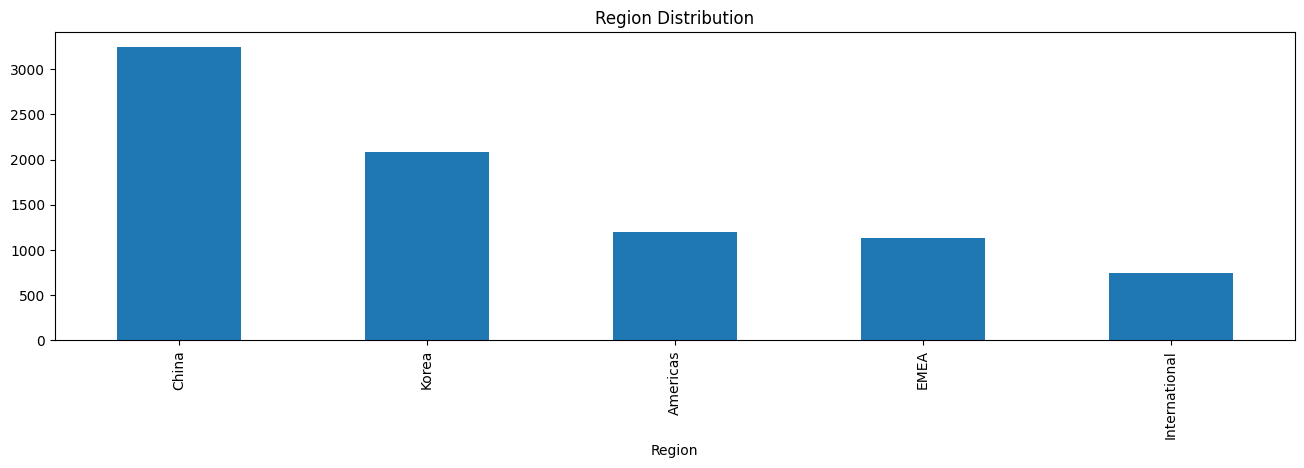

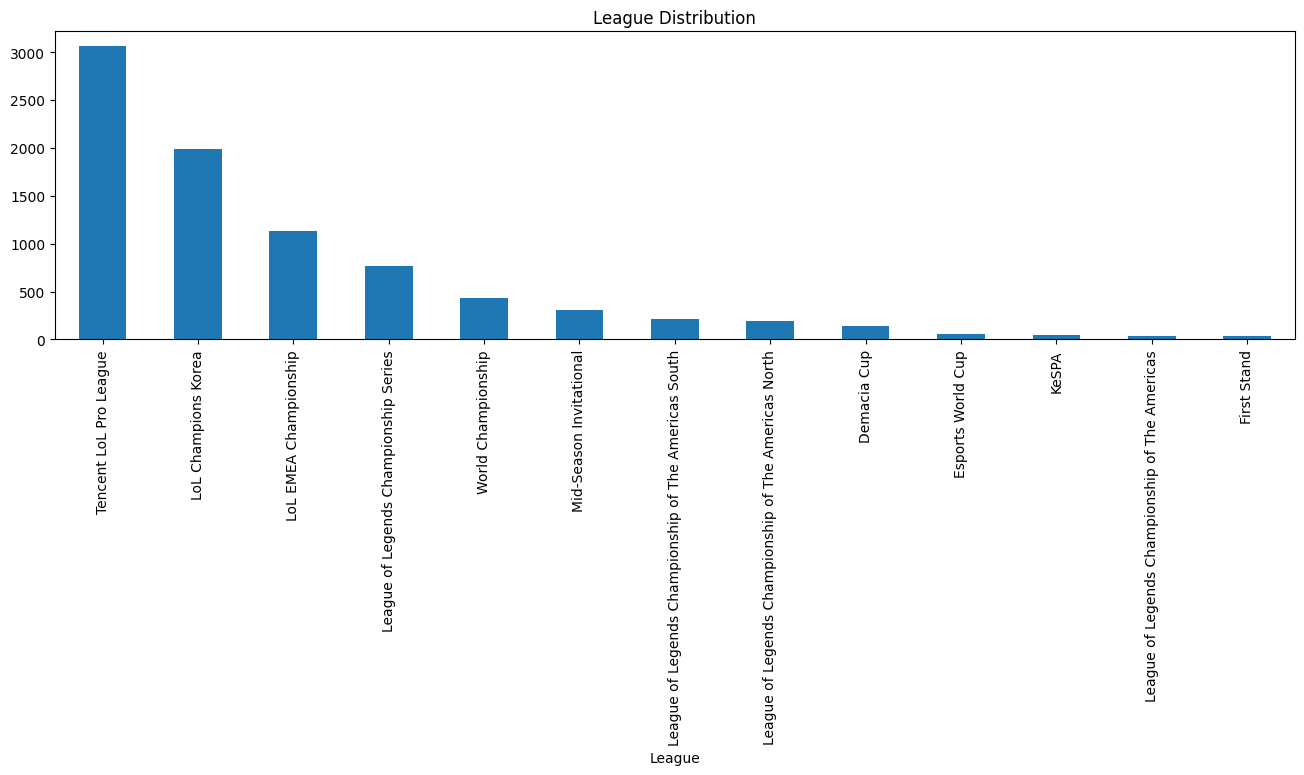

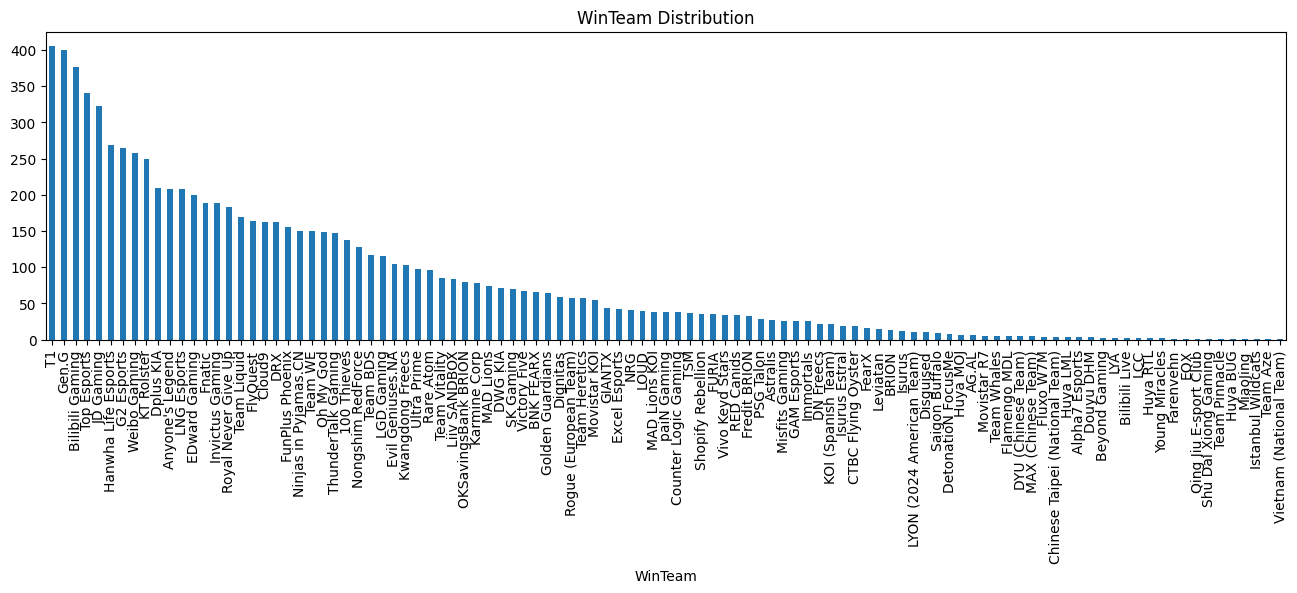

In [ ]:
regional_cols = ["Region", "League", "WinTeam"]

for col in regional_cols:
    df[col].value_counts().plot(
        kind="bar", figsize=(16, 4), title=f"{col} Distribution"
    )
    plt.show()

From these simple plots, we can get a rough idea of the data we are working with. The vast majority of the games played are in Chinese leagues (Tencent LoL Pro League) by Chinese teams. This makes sense, as the Chinese leagues are known to have the most demanding schedule, with several rounds of playoffs and regular season matches. Interestingly, however, the teams with the most wins are Korean - T1 is typically regarded as the greatest team of all time, and is highly successful, [having won two of the last three world championships](https://lol.fandom.com/wiki/World_Championship). Gen. G is typically viewed as T1's rival, and while they haven't had the same international success, [they hold the record for the most consecutive series victories](https://lol.fandom.com/wiki/Gen.G) and dominate the regular season.

Next, we will look at the types of games being played in our data:

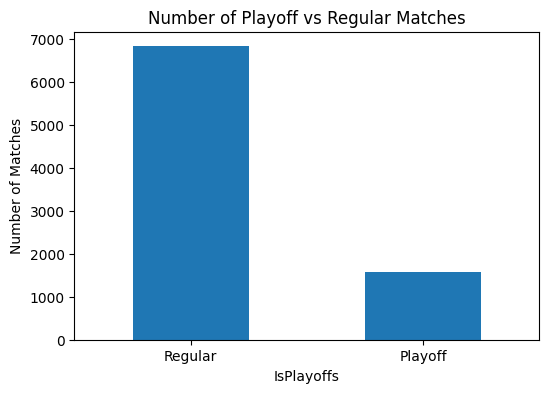

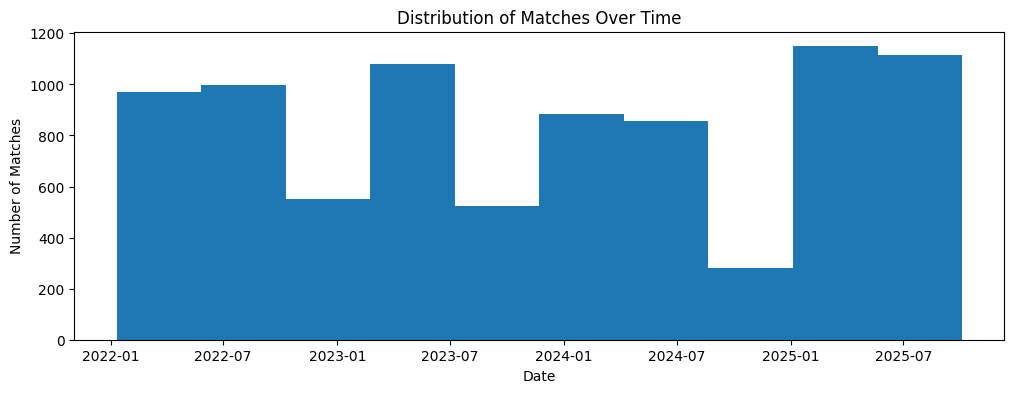

In [259]:
plt.figure(figsize=(6, 4))
df["IsPlayoffs"].value_counts().plot(kind="bar")
plt.xticks([0, 1], ["Regular", "Playoff"], rotation=0)
plt.ylabel("Number of Matches")
plt.title("Number of Playoff vs Regular Matches")
plt.show()

plt.figure(figsize=(12, 4))
plt.hist(df["DateTime UTC"], bins=10)
plt.xlabel("Date")
plt.ylabel("Number of Matches")
plt.title("Distribution of Matches Over Time")
plt.show()

This reveals that the majority of the games in our dataset are regular season games, and most are being played in the 2025 season. This also makes sense, as playoffs only represent a small portion of the season, and schedule changes have resulted in more games being played recently. This should serve to our benefit, as having more recent data will allow predictions on future games to be more well-informed, as the meta is likely to have shifted less.

## Visualizations

Now that we have a basic understanding of the data, we can begin to do more deep exploration. First, I wanted to examine the correlation of non-draft features to determine which would be the most powerful predictors of game outcome, and reveal any multicollinearity. While draft is a factor I plan to use as well in my prediction model, for this visualization I chose to include only trivially encodable features to start:


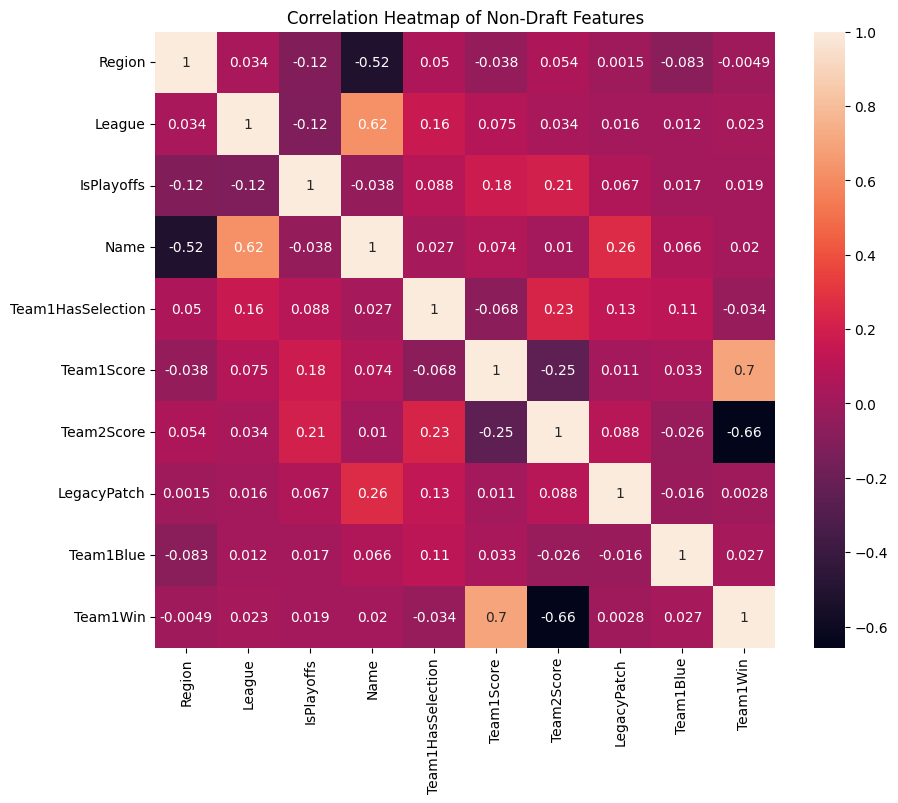

In [250]:
non_draft_features = [
    "Region",
    "League",
    "IsPlayoffs",
    "Name",
    "Team1HasSelection",
    "Team1Score",
    "Team2Score",
    "LegacyPatch",
    "Team1Blue",
    "Team1Win",
]

df_corr = df[non_draft_features].copy()

# convert patch to float for correlation purposes
df_corr["LegacyPatch"] = (
    df_corr["LegacyPatch"].astype(str).str.extract(r"(\d+\.\d+)").astype(float)
)

categorical_cols = ["Region", "League", "Name", "Team1HasSelection"]
for col in categorical_cols:
    df_corr[col] = df_corr[col].astype("category").cat.codes

corr_matrix = df_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True)
plt.title("Correlation Heatmap of Non-Draft Features")
plt.show()

From this correlation matrix, it is apparent that, outside of draft, each team's score is highly correlated with whether the game is won or lost. This could be due to psychological factors: If Team1Score is large, it means that Team1 is leading in the series, and has the momentum in their favor. If Team2Score is large, it means that Team1 is trailing, and could be on the brink of losing the series, thus applying psychosocial pressure on the players. In addition, whichever team has the higher score is also simply likely to be the better team, especially later in the series. In addition, some amount of multicollinearity exists: the name of the tournament, for example, is correlated with the current patch and the league and region the game is played in. At this point, I am not particularly concerned with this, as my goal is raw predictive accuracy, not interpretability, however I will keep this in mind when I build my model in the next phase. 

Based on this matrix alone, it would appear that some features may not have a simple correlation with team win, but intuitively can have a big impact on game outcomes. One such feature is patch, or the version of the game being played. Generally, blue side is seen as having an advantage, and it has historically been the statistically dominant side, [boasting a 52% win rate since 2021, and notably a 60% win rate at Worlds 2023](https://www.sheepesports.com/en/articles/lol-worlds-2024-in-numbers-after-week-1/en). Because of this, understanding the statistical impact of side-advantage and how it has changed over time is crucial to accurately predicting game outcomes:

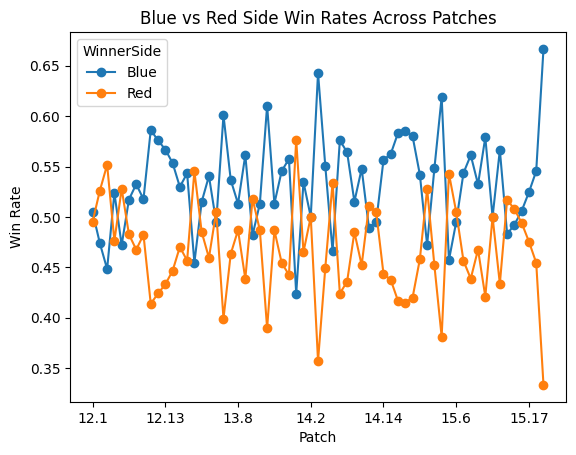

In [251]:
df["WinnerSide"] = df.apply(
    lambda row: "Blue" if row["WinTeam"] == row["Team1"] else "Red", axis=1
)

patch_winrates = (
    df.groupby(["LegacyPatch", "WinnerSide"]).size().reset_index(name="Wins")
)
total_matches = df.groupby("LegacyPatch").size().reset_index(name="Total")

patch_winrates = patch_winrates.merge(total_matches, on="LegacyPatch")
patch_winrates["WinRate"] = patch_winrates["Wins"] / patch_winrates["Total"]

winrate_pivot = patch_winrates.pivot(
    index="LegacyPatch", columns="WinnerSide", values="WinRate"
)

winrate_pivot.sort_index().plot(kind="line", marker="o")
plt.title("Blue vs Red Side Win Rates Across Patches")
plt.ylabel("Win Rate")
plt.xlabel("Patch")
plt.show()

Based on the graph, it is apparent that side can play a major role in win rate, although which side is advantaged has changed over patches. On path 14.3, for example, blue side was roughly 30% more likely to win, while between 13.10 and 14.3, the red side advantage nearly reached 10%. So historically blue side has been dominant, but that has not always been the case. Therefore, both patch and side are important in predicting game outcomes.

Next, I wanted to investigate draft-related features, starting with determining which champions are most highly prioritized overall, and which of these prioritized champions are most winning. To determine this, I graphed the 40 most picked champions by pick frequency, along with their respective win rates:

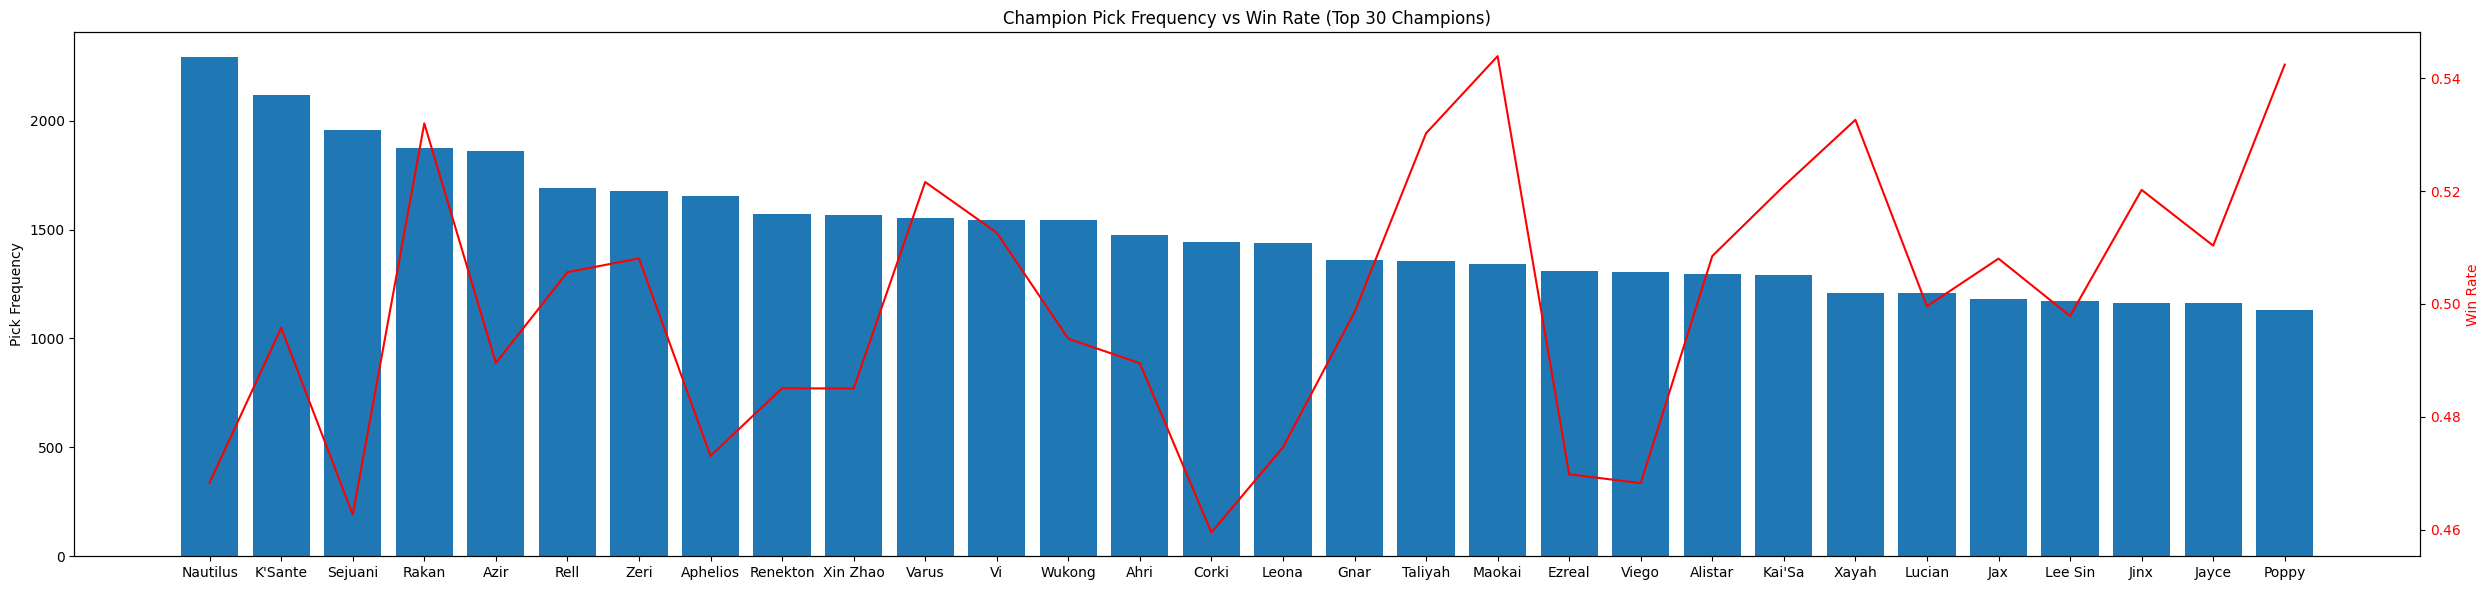

In [252]:
def explode_all_picks(
    df, region_col="Region", winteam_col="WinTeam", patch_col="LegacyPatch"
):
    picks_long = pd.concat(
        [
            df[[region_col, winteam_col, patch_col, "Team1", "Team1Picks"]].rename(
                columns={"Team1": "Team", "Team1Picks": "Picks"}
            ),
            df[[region_col, winteam_col, patch_col, "Team2", "Team2Picks"]].rename(
                columns={"Team2": "Team", "Team2Picks": "Picks"}
            ),
        ],
        ignore_index=True,
    )

    picks_long["Win"] = (picks_long["Team"] == picks_long[winteam_col]).astype(int)
    picks_long = picks_long.assign(Pick=picks_long["Picks"].str.split(",")).explode(
        "Pick"
    )
    picks_long["Pick"] = picks_long["Pick"].str.strip()
    picks_long = picks_long.drop(columns=["Picks", winteam_col])

    return picks_long


all_picks = explode_all_picks(df)

champ_stats = (
    all_picks.groupby("Pick")
    .agg(Picks=("Pick", "count"), Wins=("Win", "sum"))
    .reset_index()
)

champ_stats["WinRate"] = champ_stats["Wins"] / champ_stats["Picks"]

top_champs = champ_stats.sort_values("Picks", ascending=False).head(30)

fig, ax1 = plt.subplots(figsize=(25, 6))

ax1.bar(top_champs["Pick"], top_champs["Picks"])
ax1.set_ylabel("Pick Frequency")
ax1.tick_params(axis="y")

ax2 = ax1.twinx()
ax2.plot(top_champs["Pick"], top_champs["WinRate"], color="red")
ax2.set_ylabel("Win Rate", color="red")
ax2.tick_params(axis="y", labelcolor="red")

plt.title("Champion Pick Frequency vs Win Rate (Top 30 Champions)")
plt.tight_layout()
plt.show()

From this, we can see that the variance in win rate among the 10 most picked champions is relatively small, with the least successful, Corki, only boasting an 8% lower win rate than the most successful, Rakan. This is partially due to the amount of games played smoothing out any discrepancies in player or team performance. Clearly, however, there are champions which are more winning, with Varus, Rakan, Taliyah, Maokai, and Poppy standing out as highly successful picks. Another relationship I wanted to explore was the idea of champion affinity, or factors that influence champion picks themselves. Are certain regions more likely to pick certain champions? Does champion affinity change over time? I.E, can a champion be a staple pick for a period of time, then fall out of favor? To examine this, I reused the exploded pick data to graph champion affinity by region, and champion affinity over patches:

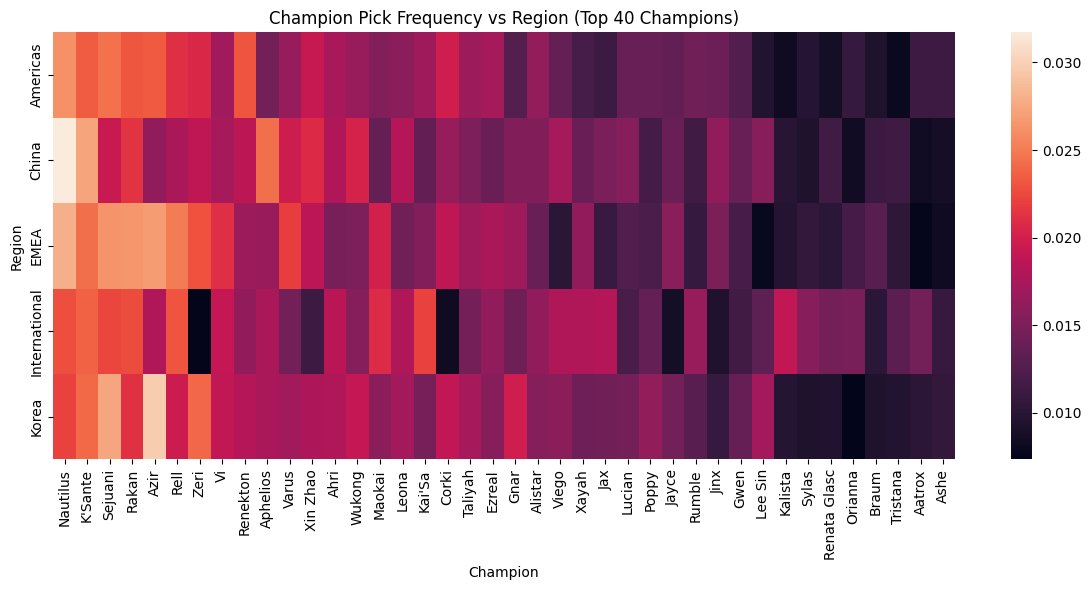

In [253]:
region_champ = all_picks.groupby(["Region", "Pick"]).size().reset_index(name="count")

mat = region_champ.pivot(index="Region", columns="Pick", values="count")
matches_per_region = all_picks.groupby("Region").size()
mat = mat.div(matches_per_region, axis=0)

top_champs = mat.sum(axis=0).sort_values(ascending=False).head(40).index
mat_small = mat[top_champs]

plt.figure(figsize=(12, 6))
sns.heatmap(mat_small)
plt.title("Champion Pick Frequency vs Region (Top 40 Champions)")
plt.xlabel("Champion")
plt.ylabel("Region")
plt.tight_layout()

From this, we can see that draft priority clearly differs among regions: EMEA, for example, has a notably high priority for the top 6 most picked champions, especially Nautilus and Rakan. This could signal that there is more draft homogeneity in EMEA - I.E, the most picked champions continue to be frequently picked, with less variation in draft than other regions. 

Also worth noting is that, just because a champion has a high pick frequency globally does not mean it is highly prioritized in every region. Nautilus, for example, has fairly high priority in every region, but his pick frequency is boosted by China's extremely high affinity for the pick. Azir sees moderate play internationally and in China, but Korea and EMEA prop up his pick frequency to top 5 status. Because of this, a pick cannot be examined as being good or bad in a vacuum. Context such as the team playing it, how practiced they are on the champion, and how experienced the player is at piloting it is equally important. A model which predicts accurately must take all these into account.

An additional source of nuance to champions picks I wanted to investigate was the impact of patch on pick frequency. Intuitively, a champion's level of power is dependant not only the champion itself, but also the version of the game being played. If the champion was recently adjusted to be more or less powerful, this could influence its priority as a pick. To examine this further, I graphed the top 40 champions pick frequency as a heatmap over all the patches in my dataset:

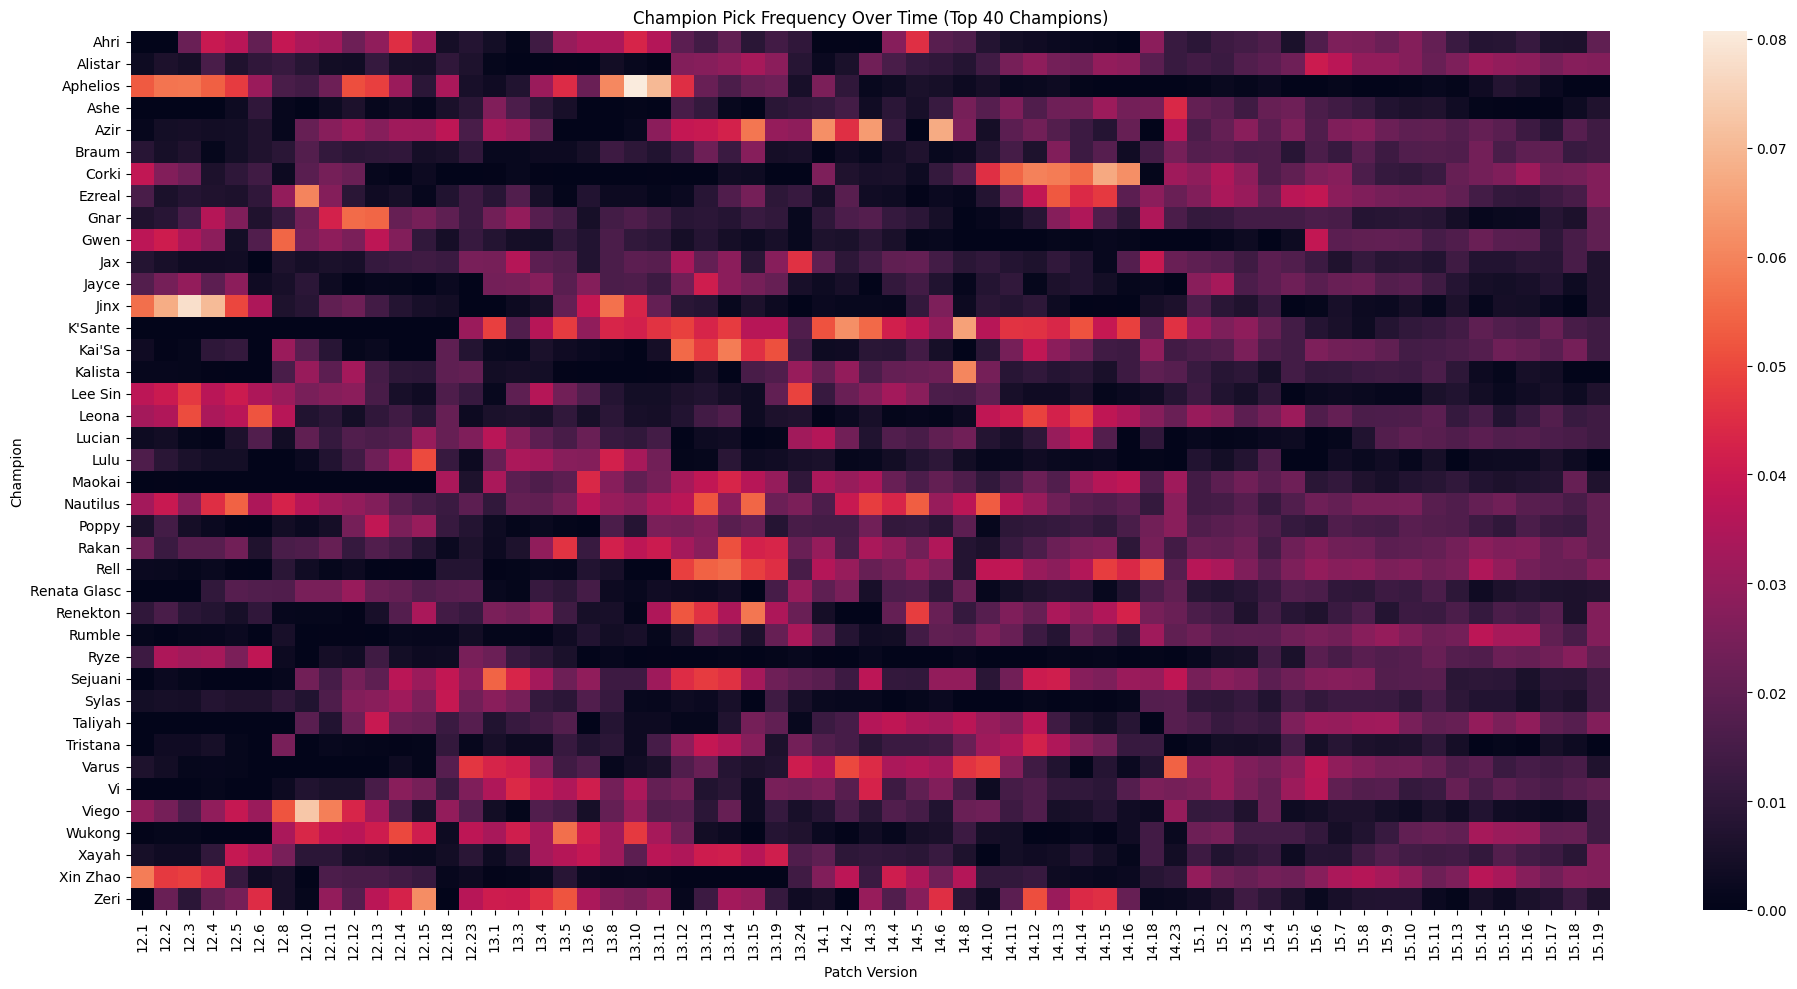

In [254]:
pickrate_over_time = (
    all_picks.groupby(["LegacyPatch", "Pick"])
    .agg(Picks=("Pick", "count"))
    .reset_index()
)

total_per_patch = pickrate_over_time.groupby("LegacyPatch")["Picks"].transform("sum")
pickrate_over_time["PickRate"] = pickrate_over_time["Picks"] / total_per_patch

top_champs = all_picks["Pick"].value_counts().head(40).index

subset = pickrate_over_time[pickrate_over_time["Pick"].isin(top_champs)]

pivot = subset.pivot(index="Pick", columns="LegacyPatch", values="PickRate").fillna(0)

pivot = pivot[sorted(pivot.columns)]

plt.figure(figsize=(20, 10))
sns.heatmap(pivot)
plt.title(f"Champion Pick Frequency Over Time (Top 40 Champions)")
plt.xlabel("Patch Version")
plt.ylabel("Champion")
plt.tight_layout()
plt.show()

This begins to paint a much clearer picture of the relationship between patch and champion power. Some of the most popular champions overall, such as Nautilus and Sejuani, generally aren't "hot" for a single patch, but rather boast consistently middling pick rates over the past three years. On the other hand, some champions, like Aphelios, Viego, and Jinx, become very highly picked for a patch or two, but then fade back to obscurity, or a lower pick frequency. What this could be indicative of is a patch change which drastically increased these champion's power level for a few patches, but which was quickly reverted to balance the game. Such "power picks" could be problematic for a predictive model, as a champion can go from incredibly powerful to weak within a month. For this reason, patch is an important consideration in determining a draft's power.

## Suprises

Overall, most of my initial expectations about the data have panned out. The most surprising findings for me were:

- The vast majority of game data is sourced from Eastern teams. I initially expected this to be the case because Eastern typically perform better and make deeper runs in international tournaments, and also have more games scheduled during their domestic seasons. The sheer difference between the games played in these regions is what surprised me the most: From the League/Region Distribution graph in Basic Data Characteristics, the amount of games played in the European and North American league combined is still less than the amount from Korea alone. Beyond that, China's raw volume of games played in the dataset is astonishing. This is important to bear in mind as I move forward with training a model, as the model will be primarily training on Eastern data, and may struggle to extrapolate to Western games.
- The impact of patch on games. I assumed that patch may have some influence on how teams draft, but the speed at which teams will decide to abandon or adopt picks was surprising to me. In the Champion Pick Frequency Over Time graph, champions like Azir, for example, will boast a nearly 7% pick frequency, then be dropped entirely the next patch. In addition, the way that side advantage swung back and forth, with the difference in win rate being as high as 30%, was unexpected. With League of Legends being such a dynamic game, this emphasizes the importance of patch in making accurate predictions.

## Next Steps

The next steps for the project will be preparing my dataset for machine learning. Although I already performed basic data cleaning and transformation for the purpose of visualization, the majority of my features are categorical and require encoding or normalization to be fed to a model. Draft, for instance, will be particularly challenging to encode: One approach could be one-hot encoding picks and bans, but this would explode the number of features I would have, and may affect model accuracy. If this turns out to be the case, I may simplify draft by grouping champions into categories, rather than encoding each individual champion as a pick. 

In addition, I plan on augmenting my dataset with additional features. At the very least, I theorize that a team's head-to-head win rate and win rate over the past X games could improve my model's accuracy. Beyond that, the Leaguepedia dataset provides access to player data, so it would be possible to create features based on each player's historical performance on the champion picked for them, although this may be more challenging.
